# US Wildfires Data Exploration

## Introduction

As someone who is working part-time in the property insurance industry and has taken EAPS 106 (Geosciences in the Cinema) in the past, I decided to work with the Wildfire Dataset provided by the U.S. Department of Agriculture.

I originally used the [1.88 Million US Wildfires dataset](https://www.kaggle.com/datasets/rtatman/188-million-us-wildfires/data) from Kaggle which contained US wildfires from 1992 to 2015. Further examination into the source of the dataset led me to a newer dataset titled: [Spatial wildfire occurrence data for the United States, 1992-2020](https://www.fs.usda.gov/rds/archive/catalog/RDS-2013-0009.6).

## Goals

I may not accomplish all of these, but it's nice to keep a list of ideas:

- Are Wildfires Becoming More Common?
- Are Wildfires Becoming Larger?
- What are the top 5 Largest US Wildfires since 1992?
- What are the Top Five States with Wildfires?
- Number of Wildfires by Size?
- Most Common Causes of Wildfires?
- Graph Wildfires by Lat and Long using Plotly

## Data
Within the [newer dataset](https://www.fs.usda.gov/rds/archive/catalog/RDS-2013-0009.6), I scrolled to the bottom and decided to download `RDS-2013-0009.6_Data_Format4_SQLITE.zip` since I was a bit familiar with SQL. 

This dataset was incredibly large. I downloaded it as a 213.96 MB compressed zip file but when unzipped, the SQLITE database was 958 MB.

Below are the introductory steps for loading the dataset into Jupyter Notebooks:

In [46]:
# imports
import sqlite3 # sql connection
import pandas as pd # data manipulation
import numpy as np # math / plotting
import matplotlib.pyplot as plt # data visualization
import plotly.express as px # plot choropleth map

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [7]:
connection = sqlite3.connect('FPA_FOD_20221014.sqlite') # create a connection to the db
cursor = connection.cursor() # create a cursor to interact w the db

# sql query to get the names of all the tables in the db
query = """
        SELECT 
            name 
        FROM 
            sqlite_master 
        WHERE 
            type='table';
        """

cursor.execute(query) # execute query

tables = cursor.fetchall() # retrieve table names

table_names = [table[0] for table in tables] # list comprehension to store table names in a list

Below is a list of tables within the database:

In [8]:
table_names

['spatial_ref_sys',
 'spatialite_history',
 'sqlite_sequence',
 'geometry_columns',
 'views_geometry_columns',
 'virts_geometry_columns',
 'geometry_columns_statistics',
 'views_geometry_columns_statistics',
 'virts_geometry_columns_statistics',
 'geometry_columns_field_infos',
 'views_geometry_columns_field_infos',
 'virts_geometry_columns_field_infos',
 'geometry_columns_time',
 'geometry_columns_auth',
 'views_geometry_columns_auth',
 'virts_geometry_columns_auth',
 'sql_statements_log',
 'SpatialIndex',
 'NWCG_UnitIdActive_20200123',
 'Fires',
 'idx_Fires_Shape',
 'idx_Fires_Shape_rowid',
 'idx_Fires_Shape_node',
 'idx_Fires_Shape_parent']

For our purposes, we'll just be using the `Fires` table. The metadata is available [here](https://www.fs.usda.gov/rds/archive/products/RDS-2013-0009.6/_metadata_RDS-2013-0009.6.html).

We'll be using Pandas from here on out to perform our exploratory analysis.

In [9]:
table_name = 'Fires'

query = f"""
        SELECT * FROM {table_name};
        """

original_fires_table = pd.read_sql_query(query, connection)

Below is a preview of what the `fires_table` looks like. 
There are 2,303,566 rows and 39 columns.

In [10]:
original_fires_table

,OBJECTID,Shape,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,...,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME
0,1,b'\x00\x01\xad\x10\x00\x00\xc8\xce\n[_@^\xc0\x...,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,...,1730,0.10,A,40.036944,-121.005833,USFS,CA,63,06063,Plumas County
1,2,b'\x00\x01\xad\x10\x00\x00\xc8\xe594\xe2\x19^\...,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,...,1530,0.25,A,38.933056,-120.404444,USFS,CA,61,06061,Placer County
2,3,b'\x00\x01\xad\x10\x00\x00x{\xac \x13/^\xc0@\x...,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,...,2024,0.10,A,38.984167,-120.735556,STATE OR PRIVATE,CA,17,06017,El Dorado County
3,4,b'\x00\x01\xad\x10\x00\x00\xc8\x13u\xd7s\xfa]\...,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,...,1400,0.10,A,38.559167,-119.913333,USFS,CA,3,06003,Alpine County
4,5,b'\x00\x01\xad\x10\x00\x00\xd0\x11y\xf8\xb6\xf...,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,...,1200,0.10,A,38.559167,-119.933056,USFS,CA,3,06003,Alpine County
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2303561,2303562,b'\x00\x01\xad\x10\x00\x00\xcc\x9a\xedDh=[\xc0...,400732978,ICS209_2020_11710294,INTERAGCY,IA-ICS209,BLM,USCOGRD,Grand Junction Field Office,COGRD,...,None,1.00,B,39.037890,-108.959500,MISSING/NOT SPECIFIED,CO,None,None,None
2303562,2303563,b'\x00\x01\xad\x10\x00\x00\xe8\x11\xda\xda1\xe...,400732979,ICS209_2020_11781527,INTERAGCY,IA-ICS209,ST/C&L,USCAMMU,Merced-Mariposa Unit,CAMMU,...,,100.00,D,37.148611,-119.503056,Private,CA,Madera,06039,Madera County
2303563,2303564,b'\x00\x01\xad\x10\x00\x00P\xf6\xa7\x9eV\x9c\\...,400732980,ICS209_2020_11815219,INTERAGCY,IA-ICS209,FS,USMTBRF,Bitterroot National Forest,MTBRF,...,None,50.00,C,46.151370,-114.442800,MISSING/NOT SPECIFIED,MT,None,None,None
2303564,2303565,b'\x00\x01\xad\x10\x00\x00\\\x87\xc8\xbbS\x07^...,400732982,ICS209_2020_11831809,INTERAGCY,IA-ICS209,FWS,USWAMCR,Mid Columbia National Wildlife Refuge Complex,WAMCR,...,1900,24892.00,G,46.670340,-120.114500,UNDEFINED FEDERAL,WA,Yakima,53077,Yakima County


In [11]:
original_fires_table.columns

Index(['OBJECTID', 'Shape', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE',
       'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_PLUS_INCIDENT_JOIN_ID', 'ICS_209_PLUS_COMPLEX_JOIN_ID',
       'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME', 'FIRE_YEAR',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME',
       'NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE',
       'NWCG_CAUSE_AGE_CATEGORY', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME',
       'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_DESCR',
       'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME'],
      dtype='object')

## Data Preparation and Cleaning

There are *a lot* of columns. 

For the purposes of this analysis, I trim down the number of columns for what's needed for me. 

Of the 39 columns, I decide to keep the following 16 columns:

| COLUMN NAME               | ATTRIBUTES |
|---------------------------|------------|
| `OBJECTID`                  | This would be used as a unique ID for a wildfire. <br> Could be good for if I wanted to group this dataset with other datasets / tables. |
| `FIRE_NAME`                 | Name of the Wildfire |
| `FIRE_YEAR`                 | Calendar year in which the fire was discovered or confirmed to exist |
| `DISCOVERY_DATE`            | Date on which the fire was discovered or confirmed to exist. <br> This could be used to extract the month and day if I wanted to go to an even more granular level. |
| `DISCOVERY_TIME`            | Time of day that the fire was discovered or confirmed to exist. <br> This could be used to see if there is a certain time of day where wildfires are more common. |
| `NWCG_CAUSE_CLASSIFICATION` | Broad classification of the reason the fire occurred (Human, Natural, Missing data / not specified / undetermined) |
| `NWCG_GENERAL_CAUSE`        | Event or circumstance that started a fire or set the stage for its occurrence. See **General Causes** for more. |
| `FIRE_SIZE`                 | The estimate of acres within the final perimeter of the fire. |
| `FIRE_SIZE_CLASS`           | Code for fire size based on the number of acres within the final fire perimeter. |
| `OWNER_DESCR`               | Name of the primary owner or entity responsible for managing the land at the point of origin of the fire at the time of the incident. |
| `CONT_DATE`                 | Date on which the fire was declared contained or otherwise controlled (mm/dd/yyyy) |
| `CONT_TIME`                 | Time of day that the fire was declared contained or otherwise controlled (hhmm) |
| `LATITUDE`                  | Geographical coordinate (latitude) |
| `LONGITUDE`                 | Geographical coordinate (longitude) |
| `STATE`                     | Two-letter state code where the fire occurred |
| `COUNTY`                    | County where the fire occurred |

In [12]:
# trim to needed columns

needed_columns = ['OBJECTID', 'FIRE_NAME', 'FIRE_YEAR', 
                  'DISCOVERY_DATE', 'DISCOVERY_TIME', 
                  'NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE', 
                  'FIRE_SIZE', 'FIRE_SIZE_CLASS',
                  'OWNER_DESCR', 'CONT_DATE', 'CONT_TIME', 
                  'LATITUDE', 'LONGITUDE', 'STATE', 'COUNTY']

fires_table = original_fires_table[needed_columns]

In [13]:
fires_table

,OBJECTID,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_TIME,NWCG_CAUSE_CLASSIFICATION,NWCG_GENERAL_CAUSE,FIRE_SIZE,FIRE_SIZE_CLASS,OWNER_DESCR,CONT_DATE,CONT_TIME,LATITUDE,LONGITUDE,STATE,COUNTY
0,1,FOUNTAIN,2005,2/2/2005,1300,Human,Power generation/transmission/distribution,0.10,A,USFS,2/2/2005,1730,40.036944,-121.005833,CA,63
1,2,PIGEON,2004,5/12/2004,0845,Natural,Natural,0.25,A,USFS,5/12/2004,1530,38.933056,-120.404444,CA,61
2,3,SLACK,2004,5/31/2004,1921,Human,Debris and open burning,0.10,A,STATE OR PRIVATE,5/31/2004,2024,38.984167,-120.735556,CA,17
3,4,DEER,2004,6/28/2004,1600,Natural,Natural,0.10,A,USFS,7/3/2004,1400,38.559167,-119.913333,CA,3
4,5,STEVENOT,2004,6/28/2004,1600,Natural,Natural,0.10,A,USFS,7/3/2004,1200,38.559167,-119.933056,CA,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2303561,2303562,JONES,2020,6/5/2020,1741,Natural,Natural,1.00,B,MISSING/NOT SPECIFIED,None,None,39.037890,-108.959500,CO,None
2303562,2303563,POWER,2020,7/11/2020,1958,Missing data/not specified/undetermined,Missing data/not specified/undetermined,100.00,D,Private,None,,37.148611,-119.503056,CA,Madera
2303563,2303564,12 MILE,2020,8/27/2020,1911,Natural,Natural,50.00,C,MISSING/NOT SPECIFIED,None,None,46.151370,-114.442800,MT,None
2303564,2303565,TAYLOR POND,2020,8/17/2020,0755,Natural,Natural,24892.00,G,UNDEFINED FEDERAL,8/20/2020,1900,46.670340,-120.114500,WA,Yakima


Let's check for empty values for each column in the dataframe:

In [14]:
# number of empty values per column
fires_table.isna().sum()

OBJECTID                          0
FIRE_NAME                    964444
FIRE_YEAR                         0
DISCOVERY_DATE                    0
DISCOVERY_TIME               789095
NWCG_CAUSE_CLASSIFICATION         0
NWCG_GENERAL_CAUSE                0
FIRE_SIZE                         0
FIRE_SIZE_CLASS                   0
OWNER_DESCR                       0
CONT_DATE                    894813
CONT_TIME                    989902
LATITUDE                          0
LONGITUDE                         0
STATE                             0
COUNTY                       665779
dtype: int64

In [15]:
# frequency of empty values per column
fires_table.isna().sum() / len(fires_table)

OBJECTID                     0.000000
FIRE_NAME                    0.418674
FIRE_YEAR                    0.000000
DISCOVERY_DATE               0.000000
DISCOVERY_TIME               0.342554
NWCG_CAUSE_CLASSIFICATION    0.000000
NWCG_GENERAL_CAUSE           0.000000
FIRE_SIZE                    0.000000
FIRE_SIZE_CLASS              0.000000
OWNER_DESCR                  0.000000
CONT_DATE                    0.388447
CONT_TIME                    0.429726
LATITUDE                     0.000000
LONGITUDE                    0.000000
STATE                        0.000000
COUNTY                       0.289021
dtype: float64

This already gives us some interesting insights.

`FIRE_NAME` (NA -> 'Unnamed') <br>
Of the 2.3 million wildfires, 41.86% of them are unnamed wildfires (964,444 total). We could potentially see if there is a correlation between fire size and if a wildfire has a name. This could be a good goal if I decide to further work on this project. We'll keep this column for now and replace the empty values with 'Unnamed'. We should also change the names from CAPSLOCK to Title Case.

`DISCOVERY_TIME` (Drop) <br>
There are also 789,095 wildfires that have an unknown discovery time (34.25%). Of these wildfires, we could possibly see if the cause is known or unknown. If I was involved with the US Department of Agriculture, I could be interested into looking where and why these fields are unknown. I'll drop this column because this metric is too granular.

`CONT_DATE` and `CONT_TIME` (Drop) <br>
This shows that 38.84% and 42.97% (for date and time respectively) of wildfires have unknown times when the wildfire was contained. For the purposes of this analysis I will drop these columns.

`COUNTY` (Drop) <br>
It also looks like the `COUNTY` column is contains both numerical and categorial (string) values for the county, as well as 665,779 empty values. For the sake of this analysis, I decide to drop this column since `LATITUDE` and `LONGITUDE` would be sufficient enough to plot.

We should have 12 columns total.

We'll accomplish this below:

In [47]:
# fill empty values in FIRE_NAME col
fires_table['FIRE_NAME'] = fires_table['FIRE_NAME'].fillna('Unnamed')
fires_table['FIRE_NAME'] = fires_table['FIRE_NAME'].str.title()

In [17]:
# drop columns
fires_table = fires_table.drop(['DISCOVERY_TIME', 'CONT_DATE', 'CONT_TIME', 'COUNTY'], axis=1)

Let's also sort the table by `DISCOVERY_DATE` (old to new)

In [18]:
fires_table = fires_table.sort_values(by='DISCOVERY_DATE')
fires_table

,OBJECTID,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,NWCG_CAUSE_CLASSIFICATION,NWCG_GENERAL_CAUSE,FIRE_SIZE,FIRE_SIZE_CLASS,OWNER_DESCR,LATITUDE,LONGITUDE,STATE
744296,744297,Unnamed,1992,1/1/1992,Missing data/not specified/undetermined,Missing data/not specified/undetermined,1.0,B,MISSING/NOT SPECIFIED,33.058333,-79.979167,SC
745557,745558,Unnamed,1992,1/1/1992,Missing data/not specified/undetermined,Missing data/not specified/undetermined,0.2,A,MISSING/NOT SPECIFIED,33.358333,-81.137500,SC
745589,745590,Unnamed,1992,1/1/1992,Missing data/not specified/undetermined,Missing data/not specified/undetermined,0.6,B,MISSING/NOT SPECIFIED,33.275000,-81.258333,SC
745851,745852,Unnamed,1992,1/1/1992,Missing data/not specified/undetermined,Missing data/not specified/undetermined,4.0,B,MISSING/NOT SPECIFIED,33.379167,-80.620833,SC
746120,746121,Unnamed,1992,1/1/1992,Missing data/not specified/undetermined,Missing data/not specified/undetermined,2.0,B,MISSING/NOT SPECIFIED,32.841667,-80.641667,SC
...,...,...,...,...,...,...,...,...,...,...,...,...
2297798,2297799,Ruby Ridge,2020,9/9/2020,Natural,Natural,0.1,A,PRIVATE,48.622886,-116.483314,ID
2283946,2283947,Davis 3,2020,9/9/2020,Human,Arson/incendiarism,11.1,C,USFS,39.881665,-120.507713,CA
2264628,2264629,Little Creek (1) (12),2020,9/9/2020,Natural,Natural,7.0,B,STATE,30.414700,-82.640400,FL
2278140,2278141,Como St Wild,2020,9/9/2020,Missing data/not specified/undetermined,Missing data/not specified/undetermined,1.0,B,MISSING/NOT SPECIFIED,33.606388,-117.269765,CA


## Data Analysis and Exploration

### Question: Are Wildfires Becoming More Common?
In order to determine if wildfires are becoming more common, I created a frequency table by `FIRE_YEAR` and the number of wildfires.

In [19]:
wildfire_freq_by_year_df = pd.DataFrame(fires_table['FIRE_YEAR'].value_counts()).sort_index()
wildfire_freq_by_year_df = wildfire_freq_by_year_df.reset_index()
wildfire_freq_by_year_df = wildfire_freq_by_year_df.rename(columns = {'index': 'FIRE_YEAR', 'FIRE_YEAR': 'FREQ'})

In [20]:
# show head and tail
pd.concat([wildfire_freq_by_year_df.head(5), wildfire_freq_by_year_df.tail(5)])

,FIRE_YEAR,FREQ
0,1992,67961
1,1993,61975
2,1994,75932
3,1995,71440
4,1996,75561
24,2016,81993
25,2017,82279
26,2018,80860
27,2019,63557
28,2020,73262


Next, I plot a line graph of the wildfire occurrences over time (based on the table above): 

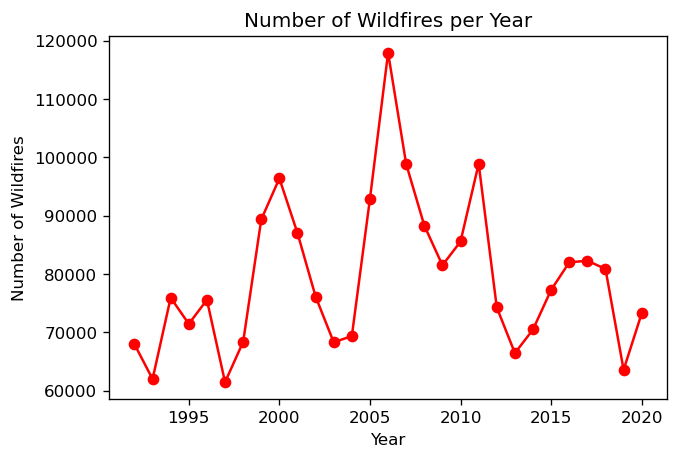

In [21]:
plt.plot(wildfire_freq_by_year_df['FIRE_YEAR'], wildfire_freq_by_year_df['FREQ'], marker='o', color='red')

plt.xlabel('Year')
plt.ylabel('Number of Wildfires')
plt.title('Number of Wildfires per Year')

plt.gcf().set_dpi(120)

plt.show()

Here's the same plot but with a regression line.

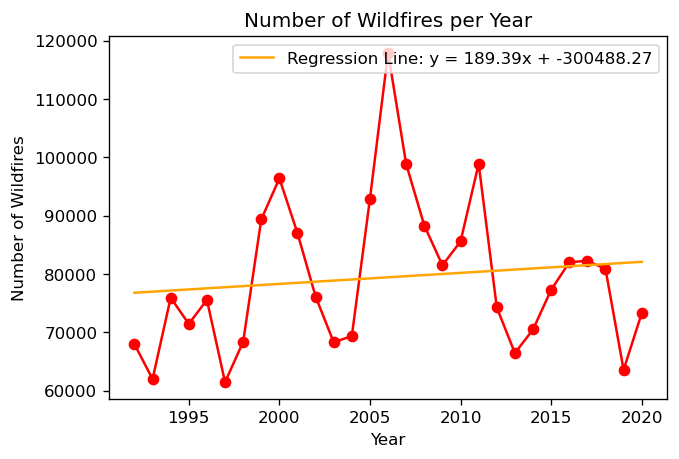

In [22]:
# copy above graph
plt.plot(wildfire_freq_by_year_df['FIRE_YEAR'], wildfire_freq_by_year_df['FREQ'], marker='o', color='red')

# calculate coefficients of regression line
coefficients = np.polyfit(wildfire_freq_by_year_df['FIRE_YEAR'], wildfire_freq_by_year_df['FREQ'], 1)
slope, intercept = coefficients

# create regression line
regression_line = slope * wildfire_freq_by_year_df['FIRE_YEAR'] + intercept

# plot regression line
plt.plot(wildfire_freq_by_year_df['FIRE_YEAR'], regression_line, color='orange', label=f'Regression Line: y = {slope:.2f}x + {intercept:.2f}')

plt.xlabel('Year')
plt.ylabel('Number of Wildfires')
plt.title('Number of Wildfires per Year')
plt.legend()

plt.gcf().set_dpi(120)

plt.show()

To determine how "fit" this regression line is, I calculate the correlation between the frequency and fire year.

We should receive a correlation coefficient value between -1 and 1, where -1 indicates a perfect negative correlation, 1 indicates a perfect positive correlation, and 0 indicates no correlation.

In [23]:
correlation_coefficient = np.corrcoef(wildfire_freq_by_year_df['FREQ'], regression_line)[0, 1]

print(f"Correlation coefficient of the regression line: {round(correlation_coefficient, 5)}")

Correlation coefficient of the regression line: 0.12339


Since the correlation of between these two variables ($.12$) is close to 0, there is a very weak positive correlation between the number of wildfires and years.

### Result: Are Wildfires Becoming More Common?
**No**, because there is a very weak positive correlation between the number of wildfires and wildfire years, we cannot say for certain that wildfires are becoming more common.

### Question: Are Wildfires Becoming Larger?
Lets find the total sum of wildfire sizes in a given year and follow similar steps to the previous question.
1. Create an aggregated table
2. Plot the sum of wildfire sizes by year
3. Add a line of best fit
4. Calculate Correlation Coefficient

Below is the aggregated table:

In [24]:
fire_size_by_year_df = fires_table.groupby('FIRE_YEAR').agg({'FIRE_SIZE': 'sum'}).reset_index()
pd.concat([fire_size_by_year_df.head(5), fire_size_by_year_df.tail(5)])

,FIRE_YEAR,FIRE_SIZE
0,1992,2.199923e+06
1,1993,2.191587e+06
2,1994,4.115582e+06
3,1995,2.049553e+06
4,1996,6.004833e+06
24,2016,5.362282e+06
25,2017,1.024566e+07
26,2018,8.243602e+06
27,2019,4.915668e+06
28,2020,1.049538e+07


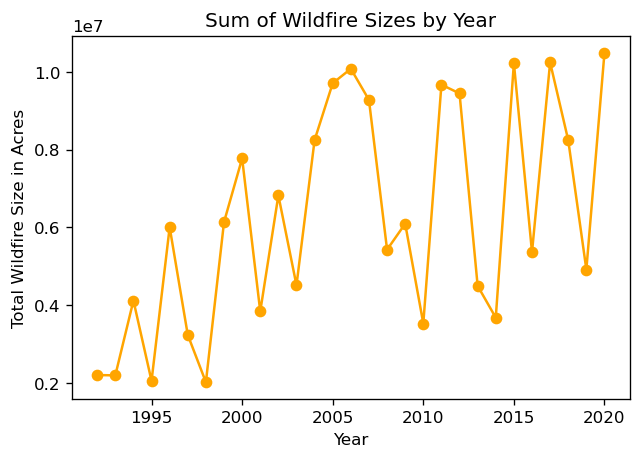

In [25]:
plt.plot(fire_size_by_year_df['FIRE_YEAR'], fire_size_by_year_df['FIRE_SIZE'], marker='o', color='orange')

plt.xlabel('Year')
plt.ylabel('Total Wildfire Size in Acres')
plt.title('Sum of Wildfire Sizes by Year')

plt.gcf().set_dpi(120)

plt.show()

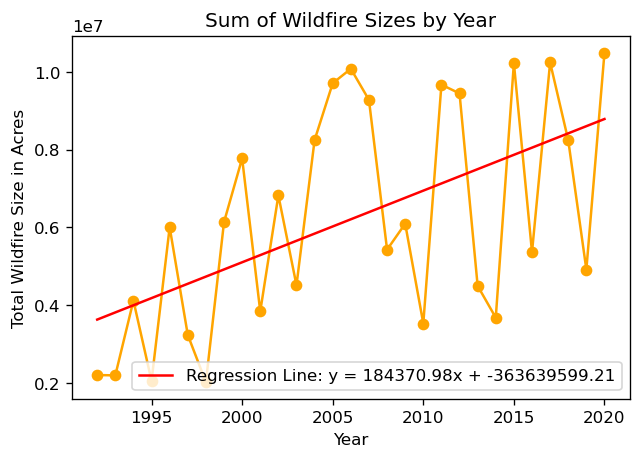

In [26]:
# copy above graph
plt.plot(fire_size_by_year_df['FIRE_YEAR'], fire_size_by_year_df['FIRE_SIZE'], marker='o', color='orange')

# calculate coefficients of regression line
coefficients = np.polyfit(fire_size_by_year_df['FIRE_YEAR'], fire_size_by_year_df['FIRE_SIZE'], 1)
slope, intercept = coefficients

# create regression line
regression_line = slope * fire_size_by_year_df['FIRE_YEAR'] + intercept

# plot regression line
plt.plot(fire_size_by_year_df['FIRE_YEAR'], regression_line, color='red', label=f'Regression Line: y = {slope:.2f}x + {intercept:.2f}')

plt.xlabel('Year')
plt.ylabel('Total Wildfire Size in Acres')
plt.title('Sum of Wildfire Sizes by Year')
plt.legend()

plt.gcf().set_dpi(120)

plt.show()

In [27]:
correlation_coefficient = np.corrcoef(fire_size_by_year_df['FIRE_SIZE'], regression_line)[0, 1]

print(f"Correlation coefficient of the regression line: {round(correlation_coefficient, 5)}")

Correlation coefficient of the regression line: 0.54821


Given that the correlation is $.54$, we can say that there is a moderate positive correlation between the total size of wildfires over time.

### Result: Are Wildfires Becoming More Common?
**Yes**, because there is a moderately positive correlation between the total size of wildfires in a given year, we can say for certain that wildfires are becoming larger over time.

### Top 10 Largest US Wildfires since 1992

In [48]:
fires_table.sort_values(by='FIRE_SIZE', ascending=False).head(10)

,OBJECTID,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,NWCG_CAUSE_CLASSIFICATION,NWCG_GENERAL_CAUSE,FIRE_SIZE,FIRE_SIZE_CLASS,OWNER_DESCR,LATITUDE,LONGITUDE,STATE
2042980,2042981,Oks - Starbuck,2017,3/7/2017,Missing data/not specified/undetermined,Missing data/not specified/undetermined,662700.0,G,MISSING/NOT SPECIFIED,36.774470,-100.175200,OK
211267,211268,Inowak,1997,6/25/1997,Natural,Natural,606945.0,G,BLM,61.982700,-157.085700,AK
2284521,2284522,Doe,2020,8/16/2020,Natural,Natural,589368.0,G,USFS,39.765255,-122.672914,CA
1578390,1578391,Long Draw,2012,7/8/2012,Natural,Natural,558198.3,G,BLM,42.391894,-117.893687,OR
1458490,1458491,Wallow,2011,5/29/2011,Human,Recreation and ceremony,538049.0,G,USFS,33.606111,-109.449722,AZ
305530,305531,Boundary,2004,6/13/2004,Natural,Natural,537627.0,G,STATE,65.266300,-146.885800,AK
1214259,1214260,Minto Flats South,2009,6/21/2009,Natural,Natural,517078.0,G,TRIBAL,64.746700,-149.504700,AK
153680,153681,Biscuit,2002,7/13/2002,Natural,Natural,499945.0,G,USFS,42.038889,-123.911667,OR
305629,305630,Dall City,2004,7/6/2004,Natural,Natural,483280.0,G,FWS,66.302900,-149.884300,AK
352695,352696,Hwy 152,2006,3/12/2006,Human,Missing data/not specified/undetermined,479549.0,G,PRIVATE,35.667800,-101.370800,TX


### Top Five States with Wildfires

In [29]:
state_wildfire_freq_df = pd.DataFrame(fires_table.groupby(['STATE']).size()).reset_index()
state_wildfire_freq_df.columns = ['State', 'Wildfire Count']
top_5_wildfire_states = state_wildfire_freq_df.head()
top_5_wildfire_states

,State,Wildfire Count
0,AK,15195
1,AL,74833
2,AR,37947
3,AZ,104956
4,CA,251881


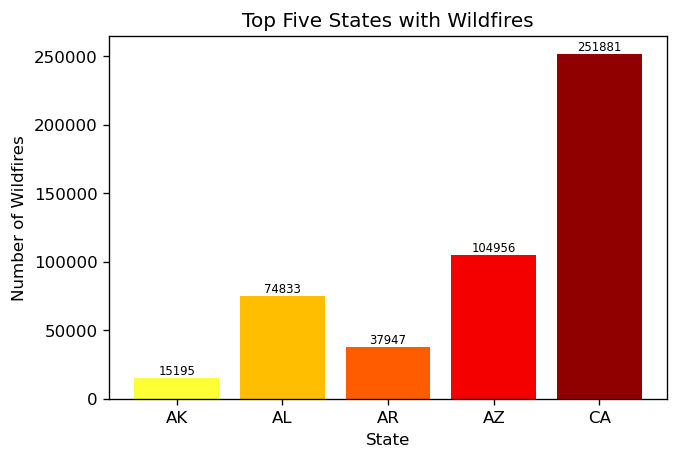

In [30]:
colors = plt.cm.hot(np.linspace(.8, .2, len(top_5_wildfire_states)))
plt.bar(top_5_wildfire_states['State'], top_5_wildfire_states['Wildfire Count'], color=colors)

plt.xlabel('State')
plt.ylabel('Number of Wildfires')
plt.title('Top Five States with Wildfires')

# add labels above each bar
for i, v in enumerate(top_5_wildfire_states['Wildfire Count']):
    plt.text(i, v + 2500, str(v), ha='center', fontsize=7)

plt.gcf().set_dpi(120)

plt.show()

### Number of Wildfires by `FIRE_SIZE_CLASS`

Below is a chart of how `FIRE_SIZE_CLASS` is classified:

| FIRE_SIZE_CLASS               | FIRE_SIZE Bin (acres) |
|---------------------------|------------|
| A | 0.00 - 0.25 |
| B | 0.26 - 9.9 |
| C | 10.0 - 99.9 |
| D | 100 - 299 |
| E | 300 - 999 |
| F | 1000 - 4999 |
| G | 5000+ |

In [31]:
fire_size_class_freq = pd.DataFrame(fires_table.groupby(['FIRE_SIZE_CLASS']).size()).reset_index()
fire_size_class_freq.columns = ['FIRE_SIZE_CLASS', 'Wildfire Count']
fire_size_class_freq

,FIRE_SIZE_CLASS,Wildfire Count
0,A,876409
1,B,1104387
2,C,257096
3,D,34008
4,E,17191
5,F,9692
6,G,4783


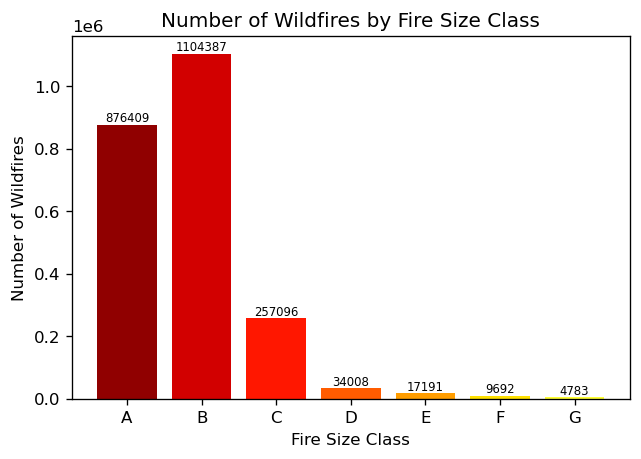

In [32]:
colors = plt.cm.hot(np.linspace(0.2, 0.8, len(fire_size_class_freq)))

plt.bar(fire_size_class_freq['FIRE_SIZE_CLASS'], fire_size_class_freq['Wildfire Count'], color=colors)

# add labels above each bar
for i, v in enumerate(fire_size_class_freq['Wildfire Count']):
    plt.text(i, v + 10000, str(v), ha='center', fontsize=7)

plt.xlabel('Fire Size Class')
plt.ylabel('Number of Wildfires')
plt.title('Number of Wildfires by Fire Size Class')

plt.gcf().set_dpi(120)

plt.show()

In [45]:
# https://medium.com/geekculture/create-a-choropleth-map-of-state-unemployment-rates-with-plotly-1354050e0cfd

fig = px.choropleth(state_wildfire_freq_df,
                    locations='State',
                    color='Wildfire Count',
                    hover_name='State',
                    color_continuous_scale='YlOrRd',
                    locationmode='USA-states',
                    scope='usa')
fig.show()

## Challenges / Next Steps
- Tried using Geopandas at first to create the US map, had trouble loading in the shape files (fixed with Plotly)
- Large dataset, takes some time to run (approx 3-4 minutes)
- Didn't have time to answer all of my questions I wanted to, also wanted to add interactivity via Streamlit
- Had trouble coming up with relational datasets
- The data is a bit too clean (but that's common from most Kaggle datasets)